# Insight Project --Birding Big Year--

In this project I intend to determine a way to see all the birds one can see on a single state, for a given time window.  For all those birdirers that want to get to the top 100 of their state on ebrid, this will be the perfect tool. The user will input the state, home address (or lat,lon), time window and birds that already have been seen*. This last one (*) is an optional thing.

In [29]:
import numpy as np
import geopandas as gpd
import pickle
import googlemaps
import pandas as pd
import psycopg2

from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# import matplotlib
# from mpl_toolkits.axes_grid1 import make_axes_locatable

import SetCover
import DBScaner
import Definition
import Itinerary

def save_fig(name):
    fig.savefig(name,dpi=80,bbox_inches='tight', pad_inches=0.02, format = 'png')

%matplotlib inline

In [2]:
# import importlib
# importlib.reload(Itinerary)

# Here we go 2.0

In [3]:
# geocode_result = gmaps.geocode('{}'.format(userHomeBase))
# pickle.dump(geocode_result, open("./geocode_result_Madison.p", "wb" ))

In [4]:
geocode_result = pickle.load(open("./geocode_result_Madison.p", "rb" ))

In [5]:
state_long = geocode_result[0]['address_components'][2]['long_name']
state_short = geocode_result[0]['address_components'][2]['short_name']

In [6]:
lat = geocode_result[0]['geometry']['location']['lat']
lng = geocode_result[0]['geometry']['location']['lng']

### The ebird Data

The bird data has been trasnform to a Postgres SQL database.  This section of the code reads form this database to do the calculations. 

In [7]:
dbname = Definition.DBNAME
username = Definition.USERNAME
pswd = Definition.PSWD

In [8]:
## Now try the same queries, but in python!

# connect:
con = None
con = psycopg2.connect(database = dbname, user = username, host='localhost', password=pswd)

# query:
sql_query = """
SELECT * FROM test WHERE year = 2018;
"""
dfTrain = pd.read_sql_query(sql_query,con)

### Clustering using BDSCAN

BDSCAN is a density clustering that will tell where is popular for people to go birding (based on the desnity of hotsopts).  I will define a cluster as having atleast 3 point and with a maximum distance of 0.05degrees or about 5km.  With that I will optain where does each hotspot ('LOCALITY') belongs to. If '-1' they are not part of any cluster.

In [9]:
DBScaner.cluster_selection?

In [10]:
dfcluster, labels, n_clusters_ = DBScaner.cluster_selection(dfTrain, eps=0.02, min_samples=2)

In [11]:
n_clusters_

281

281

In [12]:
dfcluster.head(5)

,locality,latitude,longitude,db_cluster
0,Lost Creek Wetland (Stevens Point),44.533456,-89.465532,-1
1,UW Madison Arboretum (general),43.041355,-89.429097,0
2,Red Arrow Park,45.085978,-87.587878,1
3,Crex Meadows SWA,45.842964,-92.620310,-1
4,Stricker's Pond,43.087100,-89.509400,2


,locality,latitude,longitude,db_cluster
0,Lost Creek Wetland (Stevens Point),44.533456,-89.465532,-1
1,UW Madison Arboretum (general),43.041355,-89.429097,0
2,Red Arrow Park,45.085978,-87.587878,1
3,Crex Meadows SWA,45.842964,-92.620310,-1
4,Stricker's Pond,43.087100,-89.509400,2


In [13]:
dfCounts = DBScaner.cluster_center(dfcluster, dfTrain)

In [14]:
dfCounts.head(5)

,locality,tot_bird_species,latitude,longitude,db_cluster
0,stakeout Hammond’s Flycatcher (2018),203.0,43.134118,-90.244394,-1
1,Yahara River--Lake Monona to Upper Mud Lake,194.0,43.045660,-89.329158,0
2,Seagull Bar SNA,95.0,45.079466,-87.588746,1
3,Tiedeman's Pond,166.0,43.090077,-89.504070,2
4,"Fortier Road, Lower WI State Riverway",99.0,43.174966,-89.890716,3


,locality,tot_bird_species,latitude,longitude,db_cluster
0,stakeout Hammond’s Flycatcher (2018),203.0,43.134118,-90.244394,-1
1,Yahara River--Lake Monona to Upper Mud Lake,194.0,43.045660,-89.329158,0
2,Seagull Bar SNA,95.0,45.079466,-87.588746,1
3,Tiedeman's Pond,166.0,43.090077,-89.504070,2
4,"Fortier Road, Lower WI State Riverway",99.0,43.174966,-89.890716,3


### Now some good plots

In [15]:
country = gpd.read_file('./gz_2010_us_040_00_5m.json')

In [16]:
unique_labels = set(labels)
colors = [plt.cm.viridis_r(each)
          for each in np.linspace(0, 1, len(unique_labels))]

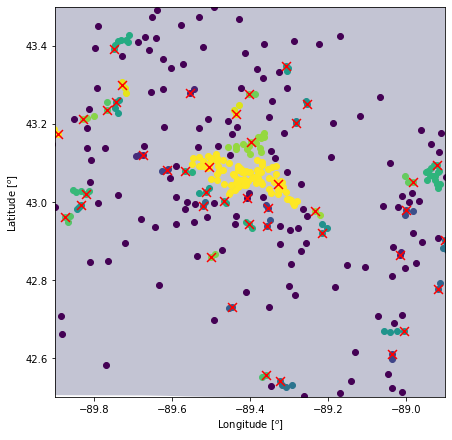

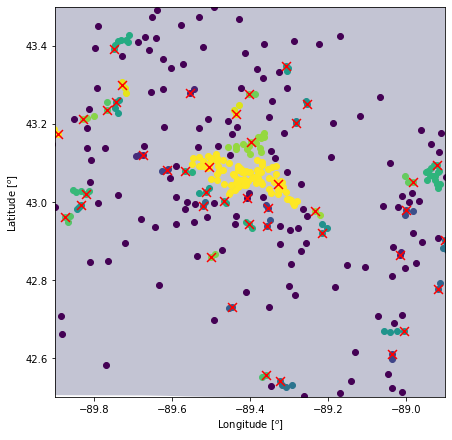

In [17]:
fig, ax = plt.subplots(1, figsize=(7,8))
base = country[country['NAME'].isin([state_long]) == True].plot(ax=ax, color='#3B3C6E', alpha = 0.3)
for i, clust in enumerate(labels):
    ax.scatter(np.array(dfcluster['longitude'])[i],np.array(dfcluster['latitude'])[i], color = colors[clust])
ax.scatter(dfCounts['longitude'],dfCounts['latitude'], marker = 'x', color = 'r', s=80)
ax.set_ylabel(r'Latitude [$^o$]')
ax.set_xlabel(r'Longitude [$^o$]')
ax.set_xlim([-89.9,-88.9])
ax.set_ylim([42.5,43.5])
save_fig('./{}-test1.png'.format(state_long))
plt.show()

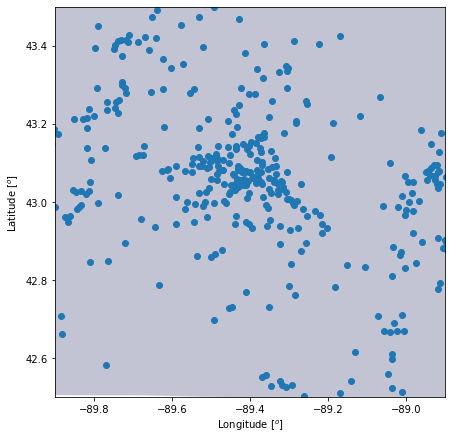

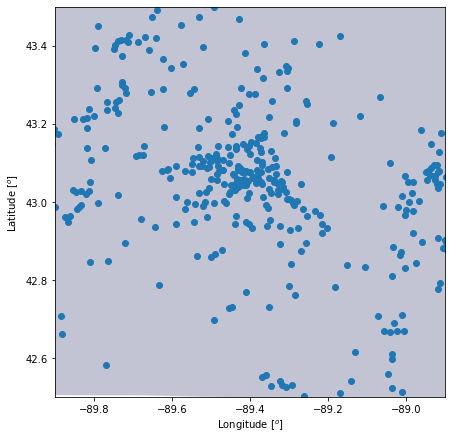

In [18]:
fig, ax = plt.subplots(1, figsize=(7,8))
base = country[country['NAME'].isin([state_long]) == True].plot(ax=ax, color='#3B3C6E', alpha = 0.3)
ax.scatter(dfcluster['longitude'],dfcluster['latitude'])
ax.set_ylabel(r'Latitude [$^o$]')
ax.set_xlabel(r'Longitude [$^o$]')
ax.set_xlim([-89.9,-88.9])
ax.set_ylim([42.5,43.5])

plt.show()
save_fig('./{}-test2.png'.format(state_long))



### Now the bird probability.

`dfbdscan` have the information of where each of the hotspots lay, in terms of their cluster.  Now in order to constuct a path is important to mask the probabilites of the of seeing a particular bird with T or F on a weekly basis.  This is critical in order to construc the sets.

In [19]:
dfProb = dfTrain.merge(dfcluster.filter(['locality','db_cluster']),
                            left_on='locality', right_on='locality', how = 'left').filter(['common_name','all_species_reported','year_week', 'db_cluster'])

In [20]:
nTime = 54
nLoc = n_clusters_
setMat = np.empty((nTime,nLoc), dtype=object)

In [21]:
dfProb[dfProb['common_name'] == 'Mallard']

,common_name,all_species_reported,year_week,db_cluster
108,Mallard,1,49,4.0
125,Mallard,1,33,56.0
269,Mallard,1,35,-1.0
307,Mallard,1,46,0.0
466,Mallard,1,34,23.0
...,...,...,...,...
683126,Mallard,1,24,-1.0
683128,Mallard,1,15,-1.0
683129,Mallard,1,18,1.0
683132,Mallard,1,32,0.0


,common_name,all_species_reported,year_week,db_cluster
108,Mallard,1,49,4.0
125,Mallard,1,33,56.0
269,Mallard,1,35,-1.0
307,Mallard,1,46,0.0
466,Mallard,1,34,23.0
...,...,...,...,...
683126,Mallard,1,24,-1.0
683128,Mallard,1,15,-1.0
683129,Mallard,1,18,1.0
683132,Mallard,1,32,0.0


In [22]:
for week in range(0,nTime):
    dfProbA = dfProb[dfProb['year_week']== week]
    dfProb1 = dfProbA.groupby(['common_name','db_cluster']).sum().filter(['all_species_reported']).reset_index()
    dfProb1.rename(columns = {'all_species_reported':'pos_obs'}, inplace=True)
    dfProb2 = dfProbA.groupby(['db_cluster']).sum().filter(['all_species_reported']).reset_index()
    dfProb2.rename(columns = {'all_species_reported':'tot_obs'}, inplace=True)
    dfProb3 = dfProb1.merge(dfProb2, left_on='db_cluster', right_on='db_cluster', how = 'left')
    dfProb3['pos_prob'] = dfProb3['pos_obs']/dfProb3['tot_obs']
    for loc in range(0,nLoc):
        dfWeek = dfProb3[dfProb3['db_cluster'] == loc]
        dfWeek['tf'] = list(map(lambda x: 0 if x < 0.02 else 1, dfWeek['pos_prob']))
        setMat[week,loc] = set(dfWeek[dfWeek['tf'] == 1]['common_name'].values)
        

<ipython-input-22-84fe6f760c4c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfWeek['tf'] = list(map(lambda x: 0 if x < 0.02 else 1, dfWeek['pos_prob']))
<ipython-input-22-84fe6f760c4c>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfWeek['tf'] = list(map(lambda x: 0 if x < 0.02 else 1, dfWeek['pos_prob']))


In [23]:
ToMakeUniverse = list(setMat.flatten())
Universe = set(e for s in ToMakeUniverse for e in s)

In [24]:
userInput = [lat,lng]

### Calculating google distances (dist matrix)

In [25]:
gmaps = googlemaps.Client(key='{}'.format(Definition.GOOGLEKEY))

In [26]:
coorHotspot = np.empty((n_clusters_+1, 2))
coorHotspot[:,0], coorHotspot[:,1] = dfCounts['longitude'],dfCounts['latitude']

In [27]:
'''
Choose between this and the other seccion.  For test, use the other one, it does not use google dist function.
'''

# distMat = np.empty((nTime,n_clusters_))
# countBreak = divmod(n_clusters_,100)

# for i in range(0,countBreak[0]):
#     distanceMatGmaps = gmaps.distance_matrix(origins = (userInput[0],userInput[1]), 
#                                          destinations=list(coorHotspot[100*i:100*(i+1)]),
#                                          mode = 'driving', units = 'metric')
#     for j in range(100*i,100*(i+1)):
#         jj = j - 100*i
#         try:
#             distMat[:,j] = distanceMatGmaps['rows'][0]['elements'][jj]['duration']['value']/3600
#         except KeyError:
#             distMat[:,j] = 100
        
# distanceMatGmaps = gmaps.distance_matrix(origins = (userInput[0],userInput[1]), 
#                                          destinations=list(coorHotspot[countBreak[0]*100:]),
#                                          mode = 'driving', units = 'metric')

# for j in range(countBreak[0]*100,countBreak[0]*100+countBreak[1]):
#     jj = j - countBreak[0]*100
#     try:
#         distMat[:,j] = distanceMatGmaps['rows'][0]['elements'][jj]['duration']['value']/3600
#     except KeyError:
#         distMat[:,j] = 100

#==========================================================================
#==========================================================================
#==========================================================================

distMat = np.random.rand(nTime*n_clusters_).reshape((nTime,n_clusters_))

In [30]:
setList, locList = SetCover.set_cover_weighted_greedy(Universe, ToMakeUniverse,list(distMat.flatten()))

In [31]:
outLoc = Itinerary.location_list_maker(dfCounts,locList, nTime, n_clusters_)

In [32]:
mapMarkerList = Itinerary.google_map_marker_list(dfCounts, outLoc)

In [33]:
userOut2 = Itinerary.dic_user_ouput_maker(dfCounts,locList,nTime, nLoc)

In [52]:
len(setList)

103

103

In [53]:
len(locList)

103

103

In [107]:
def google_map_marker_list(df, locations):
    '''
    Makes a python list that is use to generate the markers on the live google map.

    Arg:
        df: The dataframe form DBScaner.cluster_center.  It has the location name, lat, lgn and cluster number.
        locations:  The list of unique locations obtain from the set cover.
        
    Out:
        mapMakerList: python list with the form: [[location, latitude, longitue]....[..]]
    '''
    mapMarkerList = []
    for i in locations:
        lat = df.loc[df['locality'] == i].iloc[0]['latitude']
        lng = df.loc[df['locality'] == i].iloc[0]['longitude']
        mapMarkerList.append([i,lat,lng])
        
    return mapMarkerList


def location_list_maker(df, rawLocList, nTime, nLoc):
    '''
    Uses the raw output form the SetCover.set_cover_weighted_greedy or SetCover.set_cover_greedy methods to obtain the list of unique places that will be visited. The locations are transformed back to a (time,location) configuration and then just o a location format.
    
    Arg:
        rawLocList: Raw locations form the set_cover method.
        nTime: The number of time intervals (tipicaly 54)
        nLoc: The number of unique total hotspots.
        
    Out:
        outLoc: List of unique locations.
    
    '''
    locMat = np.linspace(1,nTime*nLoc,nTime*nLoc).reshape(nTime,nLoc)
    outLoc = set()
    for element in sorted(rawLocList):
        week,loc = np.where(locMat == element)
        outLoc |= set([df.loc[df['db_cluster'] == loc[0]].iloc[0]['locality']])
    outLoc = list(outLoc)
    return outLoc

def dic_user_ouput_maker(df, rawLocList, nTime, nLoc):
    '''
    Creates the dictionary that will be use to give the user the output it required.  The keys will be the different weeks and the entries the different location as labels.  The locations most likely will not make sence the the user and that is why the will have coordinates.
    
    Arg:
        rawLocList: Raw locations form the set_cover method.
        nTime: The number of time intervals (tipicaly 54)
        nLoc: The number of unique total hotspots.
        
    Out:
        userOut: dic with keys with the form of: 'week 1' and the values is a list of the different locations to visit.
    '''

    locMat = np.linspace(1,nTime*nLoc,nTime*nLoc).reshape(nTime,nLoc)

    userOut = {}
    for element in sorted(rawLocList):
        week,loc = np.where(locMat == element)
        placeNew = df.loc[df['db_cluster'] == loc[0]].iloc[0]['locality']
        key = 'week {}'.format(str(week[0]))
        if key in userOut.keys():
            placeOld = userOut[key]
            placeOld.extend([placeNew])
            userOut[key] = placeOld
        else:
            userOut[key] = [placeNew]
            
    return userOut

def table_creator(dfCounts, locList, setList, nTime, nLoc):
    locMat = np.linspace(1,nTime*nLoc,nTime*nLoc).reshape(nTime,nLoc)
    numLoc = len(locList)
    arrayWeeks = np.empty((numLoc), dtype = int)
    arrayLocName = np.empty((numLoc), dtype = object)
    arrayBirds = np.empty((numLoc), dtype = object)
    arrayLat = np.empty((numLoc))
    arrayLng = np.empty((numLoc))
    for i, element in enumerate(locList):
        week,loc = np.where(locMat == element)
        arrayWeeks[i] = int(week[0]+1)
        arrayLocName[i] = dfCounts.loc[dfCounts['db_cluster'] == loc[0]].iloc[0]['locality']
        arrayLat[i] = dfCounts.loc[dfCounts['db_cluster'] == loc[0]].iloc[0]['latitude']
        arrayLng[i] = dfCounts.loc[dfCounts['db_cluster'] == loc[0]].iloc[0]['longitude']
        arrayBirds[i] = ', '.join(list(setList[i]))
    dataTable = pd.DataFrame({'Week': arrayWeeks,
                      'Place': arrayLocName,
                      'Birds': arrayBirds,
                      'Lat': arrayLat,
                      'Lgn': arrayLng})
    dataTable.sort_values(by=['Week'], inplace=True)
    dataTable = dataTable.reset_index()
    dataTable.drop(['index'], axis=1, inplace=True)
        
    return dataTable

In [88]:
for i, element in enumerate(locList):
    week,loc = np.where(locMat == element)
    arrayWeeks[i] = int(week[0]+1)
    arrayLocName[i] = dfCounts.loc[dfCounts['db_cluster'] == loc[0]].iloc[0]['locality']
    arrayLat[i] = dfCounts.loc[dfCounts['db_cluster'] == loc[0]].iloc[0]['latitude']
    arrayLng[i] = dfCounts.loc[dfCounts['db_cluster'] == loc[0]].iloc[0]['longitude']
    arrayBirds[i] = ', '.join(list(setList[i]))


In [89]:
dataTable = pd.DataFrame({'Week': arrayWeeks,
                          'Place': arrayLocName,
                          'Birds': arrayBirds,
                          'Lat': arrayLat,
                          'Lgn': arrayLng})

In [94]:
dataTable.sort_values(by=['Week'], inplace=True)

In [99]:
dataTable = dataTable.reset_index()
dataTable.drop(['index'], axis=1, inplace=True)

In [100]:
dataTable

,Week,Place,Birds,Lat,Lgn
0,2,Red Cloud Park,"Northern Shrike, Downy Woodpecker, Northern Ha...",43.833861,-91.229568
1,2,Trempealeau NWR--River Bottoms Unit,"Bald Eagle, Red-tailed Hawk, Rough-legged Hawk...",44.065094,-91.597832
2,3,Schumacher Rd. Ponds,"Red-tailed Hawk, Herring Gull, American Crow, ...",43.226397,-89.436549
3,3,Valhalla Cemetery,"Common Merganser, Northern Cardinal, European ...",43.117213,-88.020240
4,3,Petenwell Dam--River side (Adams),"Common Merganser, Northern Cardinal, Downy Woo...",44.055950,-90.019387
...,...,...,...,...,...
98,46,Mounds View Grassland--Shea Prairie Unit,"Common Merganser, European Starling, Double-cr...",42.962340,-89.873367
99,49,"Jefferson Park, Menasha","Common Merganser, Ring-necked Pheasant, Northe...",44.202266,-88.426209
100,50,South Bluff/Devil's Nose SNA,"Red-tailed Hawk, Snow Goose, Wood Duck, Hooded...",43.391171,-89.748237
101,50,Sara Park,"Red-breasted Merganser, Common Merganser, Grea...",45.472770,-89.741927


,Week,Place,Birds,Lat,Lgn
0,2,Red Cloud Park,"Northern Shrike, Downy Woodpecker, Northern Ha...",43.833861,-91.229568
1,2,Trempealeau NWR--River Bottoms Unit,"Bald Eagle, Red-tailed Hawk, Rough-legged Hawk...",44.065094,-91.597832
2,3,Schumacher Rd. Ponds,"Red-tailed Hawk, Herring Gull, American Crow, ...",43.226397,-89.436549
3,3,Valhalla Cemetery,"Common Merganser, Northern Cardinal, European ...",43.117213,-88.020240
4,3,Petenwell Dam--River side (Adams),"Common Merganser, Northern Cardinal, Downy Woo...",44.055950,-90.019387
...,...,...,...,...,...
98,46,Mounds View Grassland--Shea Prairie Unit,"Common Merganser, European Starling, Double-cr...",42.962340,-89.873367
99,49,"Jefferson Park, Menasha","Common Merganser, Ring-necked Pheasant, Northe...",44.202266,-88.426209
100,50,South Bluff/Devil's Nose SNA,"Red-tailed Hawk, Snow Goose, Wood Duck, Hooded...",43.391171,-89.748237
101,50,Sara Park,"Red-breasted Merganser, Common Merganser, Grea...",45.472770,-89.741927


In [108]:
dataTable2 = table_creator(dfCounts, locList, setList, nTime, nLoc)

In [110]:
dataTable2 == dataTable

,Week,Place,Birds,Lat,Lgn
0,True,True,True,True,True
1,True,True,True,True,True
2,True,True,True,True,True
3,True,True,True,True,True
4,True,True,True,True,True
...,...,...,...,...,...
98,True,True,True,True,True
99,True,True,True,True,True
100,True,True,True,True,True
101,True,True,True,True,True


,Week,Place,Birds,Lat,Lgn
0,True,True,True,True,True
1,True,True,True,True,True
2,True,True,True,True,True
3,True,True,True,True,True
4,True,True,True,True,True
...,...,...,...,...,...
98,True,True,True,True,True
99,True,True,True,True,True
100,True,True,True,True,True
101,True,True,True,True,True


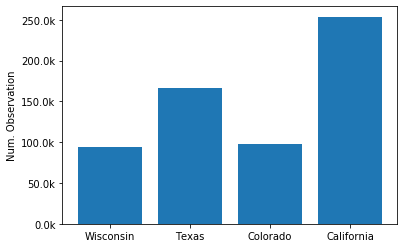

In [8]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(4)
money = [94604 , 166649, 97718, 253738]

def save_fig(name):
    fig.savefig(name,dpi=80,bbox_inches='tight', pad_inches=0.02, format = 'png')
    
def millions(x, pos):
    'The two args are the value and tick position'
    return '%1.1fk' % (x * 1e-3)


formatter = FuncFormatter(millions)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
plt.bar(x, money)
plt.ylabel('Num. Observation')
plt.xticks(x, ('Wisconsin', 'Texas', 'Colorado', 'California'))

save_fig('./state_obs.png')
plt.show()